In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention
from tensorflow.keras.models import Model

In [2]:
#Load the dataset
df = pd.read_csv("review_processed_s.csv")
df.head()

,Unnamed: 0,title,body,rating_item,rating_delivery,rating_seller,rating_marketplace,rating_total,split_ship,split_seller,split_market
0,0,"""Disappointed with my purchase of this wallet""","""Disappointed with my purchase of this wallet""...",0,5,5,4,2,While the delivery and seller both exceeded ...,While the delivery and seller both exceeded ...,While the delivery and seller both exceeded ...
1,1,"Lovely dress, but some setbacks","Lovely dress, but some setbacksI recently purc...",1,3,1,2,3,"However, I was quite disappointed with the d...",The item took much longer to arrive than exp...,"On top of that, I had some issues with the m..."
2,2,"""Misleading and Disappointing Dress Purchase""","""Misleading and Disappointing Dress Purchase""T...",1,1,1,3,1,"To add insult to injury, the delivery took...",The seller took ages to respond to my inquir...,The marketplace the vendor was found on is ...
3,3,"""Terrible Sound Quality - Disappointed with My...","""Terrible Sound Quality - Disappointed with My...",3,2,5,5,2,"Additionally, the delivery was simply unacce...","Despite these issues, I must say that the s...",While I usually love using online marketplac...
4,4,"""Functional Wallet with Delivery Hiccups""","""Functional Wallet with Delivery Hiccups""I rec...",4,3,0,4,4,"""Functional Wallet with Delivery Hiccups""I re...",0,"Regarding the marketplace, which I won't n..."


In [3]:
df = df.drop("Unnamed: 0", axis = 1)
df.head()

,title,body,rating_item,rating_delivery,rating_seller,rating_marketplace,rating_total,split_ship,split_seller,split_market
0,"""Disappointed with my purchase of this wallet""","""Disappointed with my purchase of this wallet""...",0,5,5,4,2,While the delivery and seller both exceeded ...,While the delivery and seller both exceeded ...,While the delivery and seller both exceeded ...
1,"Lovely dress, but some setbacks","Lovely dress, but some setbacksI recently purc...",1,3,1,2,3,"However, I was quite disappointed with the d...",The item took much longer to arrive than exp...,"On top of that, I had some issues with the m..."
2,"""Misleading and Disappointing Dress Purchase""","""Misleading and Disappointing Dress Purchase""T...",1,1,1,3,1,"To add insult to injury, the delivery took...",The seller took ages to respond to my inquir...,The marketplace the vendor was found on is ...
3,"""Terrible Sound Quality - Disappointed with My...","""Terrible Sound Quality - Disappointed with My...",3,2,5,5,2,"Additionally, the delivery was simply unacce...","Despite these issues, I must say that the s...",While I usually love using online marketplac...
4,"""Functional Wallet with Delivery Hiccups""","""Functional Wallet with Delivery Hiccups""I rec...",4,3,0,4,4,"""Functional Wallet with Delivery Hiccups""I re...",0,"Regarding the marketplace, which I won't n..."


In [4]:
X_shipment = df["split_ship"].values
X_seller = df["split_seller"].values
X_market = df["split_market"].values
y = df["rating_total"].values

In [5]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_shipment + X_seller + X_market)
X_shipment_seq = tokenizer.texts_to_sequences(X_shipment)
X_seller_seq = tokenizer.texts_to_sequences(X_seller)
X_market_seq = tokenizer.texts_to_sequences(X_market)

In [6]:
maxlen = 100
X_shipment_padded = pad_sequences(X_shipment_seq, padding='post', maxlen=maxlen)
X_seller_padded = pad_sequences(X_seller_seq, padding='post', maxlen=maxlen)
X_market_padded = pad_sequences(X_market_seq, padding='post', maxlen=maxlen)

In [13]:
X_shipment_train, X_shipment_test, X_seller_train, X_seller_test, X_market_train, X_market_test, y_train, y_test = train_test_split(X_shipment_padded, X_seller_padded, X_market_padded, 
                                                                                                                                    y, test_size=0.3, 
                                                                                                                                    random_state=38)

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [8]:
input_layer = Input(shape=(100,))
input_shipment = Input(shape=(100,))
input_seller = Input(shape=(100,))
input_market = Input(shape=(100,))

embedding_layer = Embedding(input_dim=5000, output_dim=100, input_length=100)

embedding_shipment = embedding_layer(input_shipment)
embedding_seller = embedding_layer(input_seller)
embedding_market = embedding_layer(input_market)

In [9]:
lstm_layer = Bidirectional(LSTM(units=64, return_sequences=True))

lstm_shipment = lstm_layer(embedding_shipment)
lstm_seller = lstm_layer(embedding_seller)
lstm_market = lstm_layer(embedding_market)

In [10]:
attention_layer = Attention()([lstm_shipment, lstm_seller, lstm_market])

dropout_layer = Dropout(0.5)(attention_layer)

output_layer = Dense(units=1, activation='sigmoid')(dropout_layer)

In [11]:
model = Model(inputs=[input_shipment, input_seller, input_market], outputs=[output_layer])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     500000      ['input_2[0][0]',                
                                                                  'input_3[0][0]',            

In [20]:
history = model.fit([X_shipment_train, X_seller_train, X_market_train], 
          y_train, epochs=10, batch_size=32, 
          validation_data=([X_shipment_test, X_seller_test, X_market_test], y_test))

Epoch 1/10
66/66 [==============================] - 11s 163ms/step - loss: -29.9526 - accuracy: 0.0500 - val_loss: -29.5496 - val_accuracy: 0.0478
Epoch 2/10
66/66 [==============================] - 11s 164ms/step - loss: -29.9528 - accuracy: 0.0500 - val_loss: -29.5496 - val_accuracy: 0.0478
Epoch 3/10
66/66 [==============================] - 11s 162ms/step - loss: -29.9528 - accuracy: 0.0500 - val_loss: -29.5496 - val_accuracy: 0.0478
Epoch 4/10
66/66 [==============================] - 11s 160ms/step - loss: -29.9530 - accuracy: 0.0500 - val_loss: -29.5496 - val_accuracy: 0.0478
Epoch 5/10
66/66 [==============================] - 11s 164ms/step - loss: -29.9529 - accuracy: 0.0500 - val_loss: -29.5496 - val_accuracy: 0.0478
Epoch 6/10
66/66 [==============================] - 11s 163ms/step - loss: -29.9531 - accuracy: 0.0500 - val_loss: -29.5496 - val_accuracy: 0.0478
Epoch 7/10
66/66 [==============================] - 11s 163ms/step - loss: -29.9533 - accuracy: 0.0500 - val_loss: -29

In [21]:
loss, accuracy = model.evaluate([X_shipment_test, X_seller_test, X_market_test], y_test)
print("Accuracy: {:.2f}%".format(accuracy * 1000))

29/29 [==============================] - 1s 35ms/step - loss: -29.5496 - accuracy: 0.0478
Accuracy: 47.78%


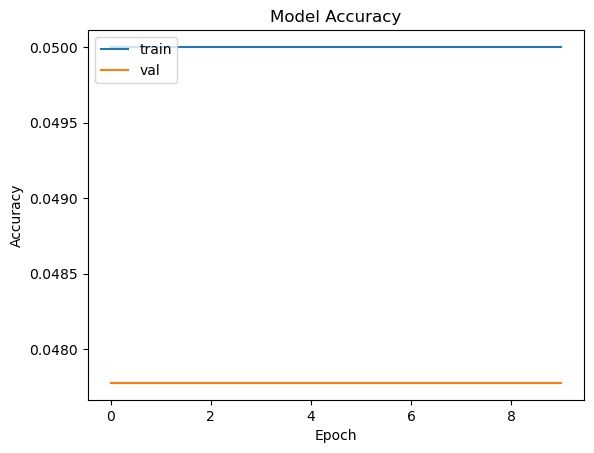

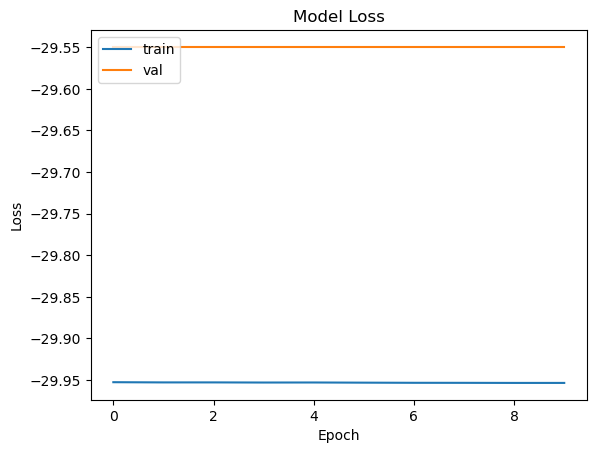

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()